In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val

%matplotlib inline

# Open Traffic Reporter Validation Service 

### 1. Generate Random Routes

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

In [4]:
# routeList = val.get_POI_routes_by_length('Paris', 1, 5, 20, gmapsKey)

In [3]:
routeList = val.get_routes_by_length('San Francisco', 1, 5, 10, mapzenKey)

#### Save or load a specific set of routes

In [ ]:
routeList = pickle.load(open('sf_routes.pkl','rb'))

In [42]:
pickle.dump(routeList, open('sf_routes.pkl','wb'))

### 2. Iterate Through Routes and Score the Matches

In [102]:
df = pd.DataFrame(columns=[
    'route','noise', 'sample_rate', 'score', 'avg_density', 'route_url',
    'trace_attr_url', 'reporter_url', 'max_edge_index_vs_shape_len'])
outDfRow = -1
saveResults = True

for i, rteCoords in enumerate(x):
    stName = rteCoords[0].keys()[0].encode("ascii", "ignore")
    endName = rteCoords[1].keys()[0].encode("ascii", "ignore")
    stLat = rteCoords[0].values()[0]["lat"]
    stLon = rteCoords[0].values()[0]["lon"]
    endLat = rteCoords[1].values()[0]["lat"]
    endLon = rteCoords[1].values()[0]["lon"]
    shape, routeUrl = val.get_route_shape(stLat, stLon, endLat, endLon)
    if shape is None:
        print routeUrl
        continue
    edges, shapeCoords, traceAttrUrl = val.get_trace_attrs(shape, shapeMatch="map_snap")
    edges = val.get_coords_per_second(shapeCoords, edges, '2768')
    avgDensity = np.mean([edge['density'] for edge in edges])
    noiseLevels = np.linspace(0, 100, 21)
    noiseLevels = [50.0]
    sampleRates = [1, 5, 10, 20, 30]
    sampleRates = [10]
    scores = []
    
    for noise in noiseLevels:
        noise = round(noise,3)
        routeName = '{0}_to_{1}'.format(stName, endName)
        
        for sampleRate in sampleRates:
            print("Route: {0} // Noise Level: {1} // Sample Rate: {2}".format(
                i, noise, sampleRate))
            Hz = round(1 / sampleRate, 3)
            outDfRow += 1
            df.loc[
                outDfRow, 
                ['route', 'noise','sample_rate','route_url','trace_attr_url']
            ] = [routeName, noise, sampleRate, routeUrl, traceAttrUrl]
            dfEdges = val.format_edge_df(edges)
            if dfEdges['num_segments'].max() > 1:
                break
            dfEdges, jsonDict, geojson = val.synthesize_gps(
                dfEdges, shapeCoords, '2768', noise=noise, sampleRate=sampleRate)
            if jsonDict is None or geojson is None:
                msg = "Trace attributes tried to call more edges than are present in the route shape".format(
                routeName)
                df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
                continue
            segments, reportUrl = val.get_reporter_segments(jsonDict)
            if segments is None:
                continue
            elif segments == 0:
                msg = 'Reporter found 0 segments.'
                df.loc[outDfRow, ['score', 'reporter_url']] = [-1, reportUrl]
                continue
            matches, score = val.get_matches(segments, dfEdges)
            df.loc[outDfRow, ['score', 'reporter_url']] = [score, reportUrl]
            df.loc[outDfRow, 'avg_density'] = avgDensity
            if saveResults:
                matches.to_csv(
                    '../data/matches_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.csv'.format(
                        stName, endName, str(noise), str(Hz)), index=False)
                with open('../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson'.format(
                    stName, endName, str(noise), str(Hz)), 'w+') as fp:
                    json.dump(geojson, fp)

Route: 0 // Noise Level: 50.0 // Sample Rate: 10


In [103]:
df['trace_attr_url'].values

array([ u'http://valhalla:8002/trace_attributes?json=%7B%22trace_options%22%3A%7B%22turn_penalty_factor%22%3A500%2C%22gps_accuracy%22%3A5%7D%2C%22shape_match%22%3A%22map_snap%22%2C%22encoded_polyline%22%3A%22ytlbgAfjwohFG%3FiG%7C%40WjAUzAe%40hBm%40zAu%40jAkt%40jsAmFnJkFlJiHvMcAxBu%40zAs%40hBm%40hCm%40hCe%40vC%5DvCGhC%3FvCFxCLfCNhCvCfc%40d%40nIl%40%7CIvNpyBbAtObAdPzLdkBl%40zKd%40rGl%40nIDxAtJbyAVdFjFm%40vl%40aHvDm%40ly%40%7DJjy%40%7BJdy%40oJ%7Cx%40%7BJry%40%7DJxa%40cFbQkBvCm%40~D%5DnC%5DbQyBhWyC%5E%3FnC%5D%7CDm%40%7Cn%40oHpC_%40nC%5Drt%40%7DItt%40oIvC%5DpC_%40%60p%40_IxC%5DfC%5Dzu%40_Jjt%40%7DIpC_%40nC%5Dxl%40aHnC%5DpC%5D~l%40aHnC_%40xC%5Dnl%40aHpC%5DvC%5Dpl%40aHvC_%40hC%5Ddn%40_IdE%5D%5C%5CrFtJpyA%5C%5CvDNtDtJbzATdE%5EtDlJbzATtDVvDvHziAVrETtEbAvN%7C%40dObAbRzAzUbBvWhLpeBrLneBbKx_BVdEz%40dPvCrd%40xBp%5DxiCaIvCM%22%2C%22costing%22%3A%22auto%22%2C%22directions_options%22%3A%7B%22units%22%3A%22kilometers%22%7D%7D'], dtype=object)

### 3. Plot the Scores

In [5]:
df['score'] = df['score'].astype(float)
df['avg_density'] = df['avg_density'].astype(float)
df['noise'] = df['noise'].astype(float)
df['sample_rate'] = df['sample_rate'].astype(float)
df['score_density'] = df['score'] * df['avg_density']

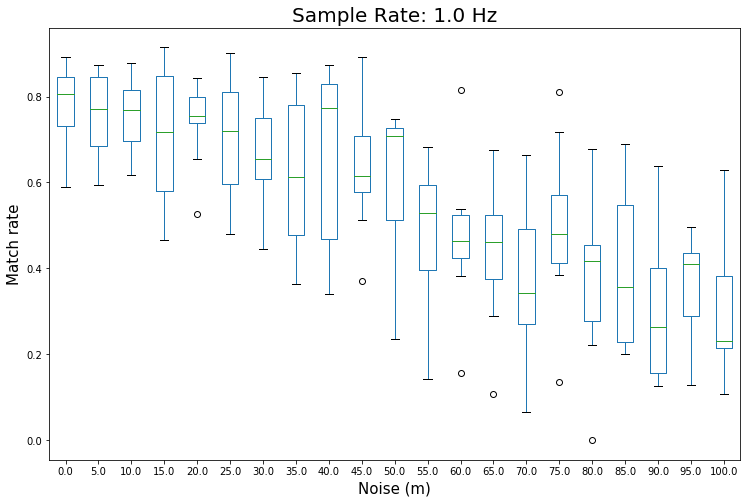

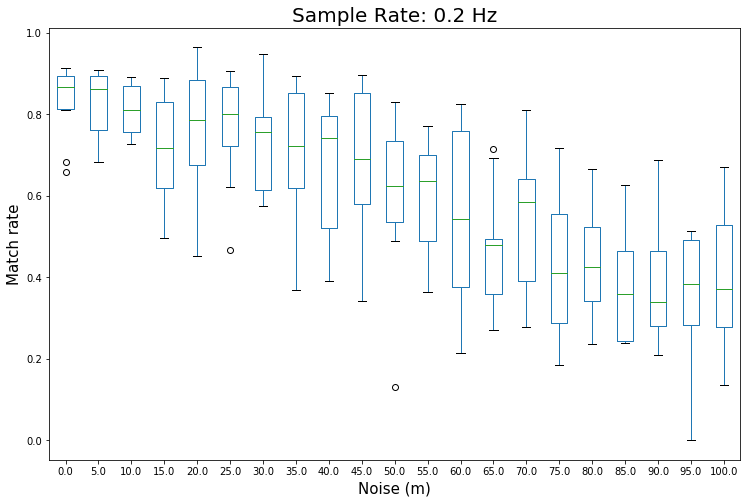

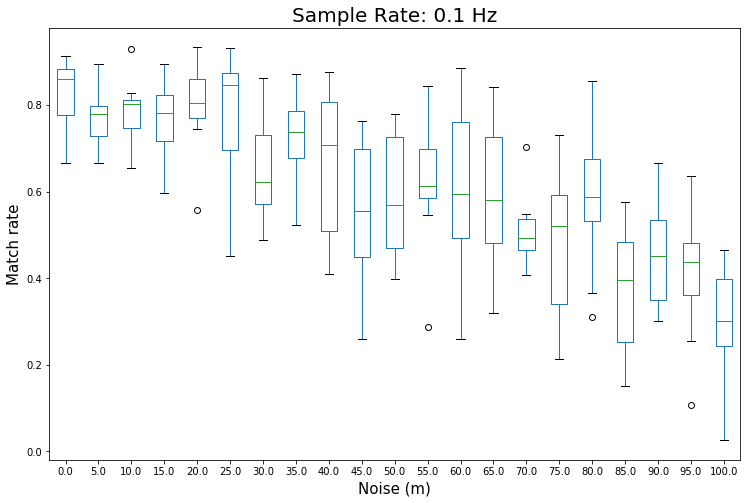

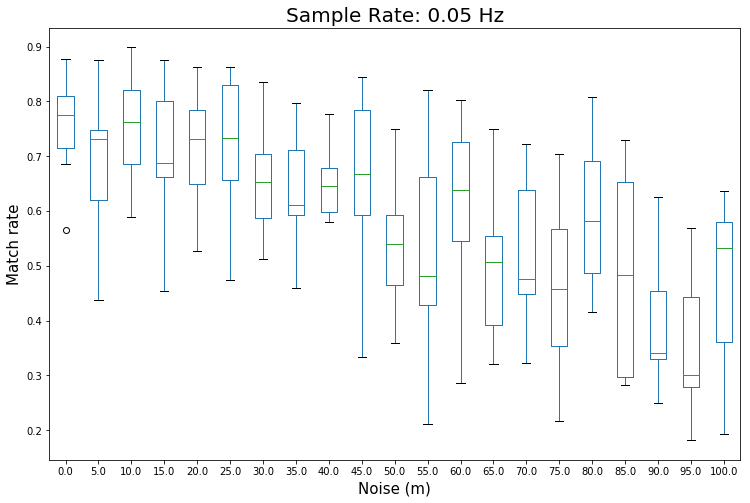

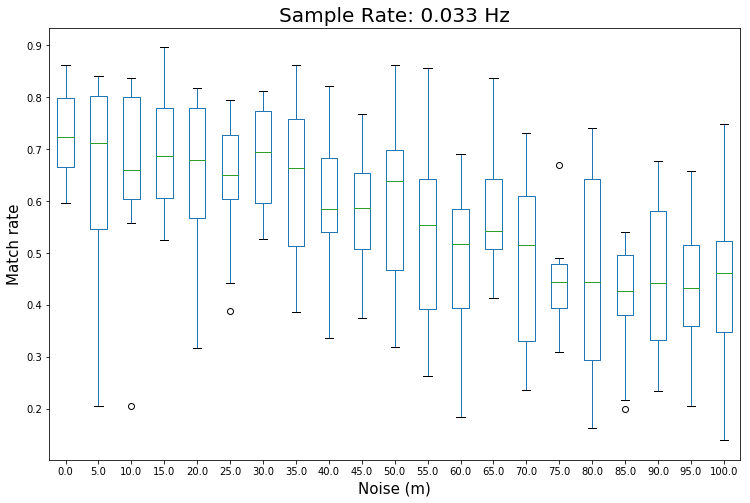

In [6]:
for rate in sampleRates:
    Hz = round(1 / rate, 3)
    fig, ax = plt.subplots(figsize=(12,8))
    df[(df['sample_rate'] == rate) & (df['score'] >= 0)].boxplot(column='score',by='noise', ax=ax, grid=False)
    ax.set_xlabel('Noise (m)', fontsize=15)
    ax.set_ylabel('Match rate', fontsize=15)
    ax.set_title('Sample Rate: {0} Hz'.format(Hz), fontsize=20)
    fig.suptitle('')
    fig.savefig('./../data/score_vs_noise_{0}_Hz.png'.format(Hz))

In [7]:
data = df.loc[df['score'] != -1, ['noise','score','sample_rate']].groupby(['sample_rate','noise']).agg('mean').reset_index()

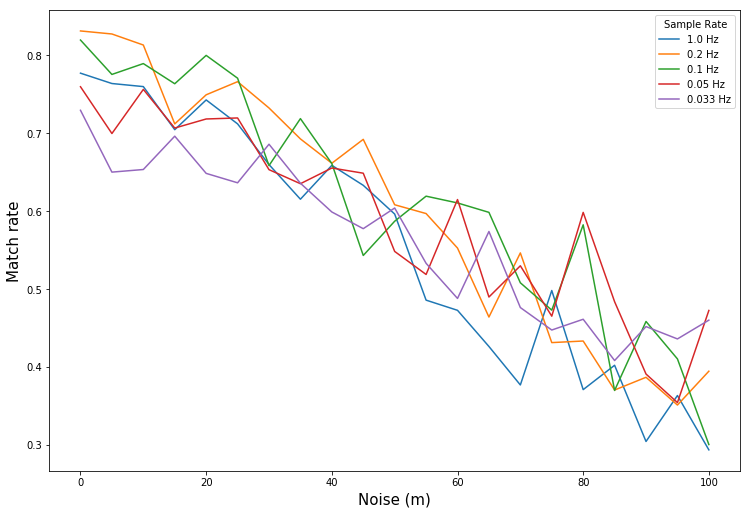

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
for rate in sampleRates:
    ax.plot(data.loc[data['sample_rate'] == rate, 'noise'],
            data.loc[data['sample_rate'] == rate, 'score'],
           label=str(round(1 / rate, 3)) + ' Hz')
ax.legend(title='Sample Rate')
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match rate', fontsize=15)
fig.savefig('../data/score_vs_noise_by_sample_rate.png')

### 4. Check for Pattern Failure 

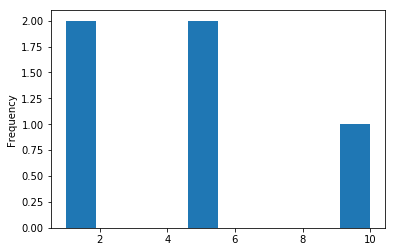

In [21]:
df.loc[df['score'] == 0, 'sample_rate'].plot(kind='hist')

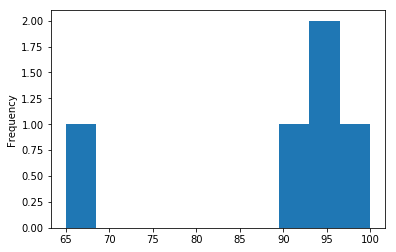

In [22]:
df.loc[df['score'] == 0,'noise'].plot(kind='hist')

### 5. Visualize Routes

In [96]:
geojsonList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

In [16]:
fname

'../data/trace_Brookside Capital Inc_to_Sunnyside Properties_w_50.0_m_noise_at_0.1_Hz.geojson'

In [40]:
x = [route for route in routeList if ('Brookside Capital Inc' in route[0].keys()) & ('Sunnyside Properties' in route[1].keys())]

In [26]:
df.loc[(df['route'] == 'Brookside Capital Inc_to_Sunnyside Properties') & (df['noise'] == 50.0),'trace_attr_url'].values[2]

u'http://valhalla:8002/trace_attributes?json=%7B%22trace_options%22%3A%7B%22turn_penalty_factor%22%3A500%2C%22gps_accuracy%22%3A5%7D%2C%22shape_match%22%3A%22map_snap%22%2C%22encoded_polyline%22%3A%22ytlbgAfjwohFG%3FiG%7C%40WjAUzAe%40hBm%40zAu%40jAkt%40jsAmFnJkFlJiHvMcAxBu%40zAs%40hBm%40hCm%40hCe%40vC%5DvCGhC%3FvCFxCLfCNhCvCfc%40d%40nIl%40%7CIvNpyBbAtObAdPzLdkBl%40zKd%40rGl%40nIDxAtJbyAVdFjFm%40vl%40aHvDm%40ly%40%7DJjy%40%7BJdy%40oJ%7Cx%40%7BJry%40%7DJxa%40cFbQkBvCm%40~D%5DnC%5DbQyBhWyC%5E%3FnC%5D%7CDm%40%7Cn%40oHpC_%40nC%5Drt%40%7DItt%40oIvC%5DpC_%40%60p%40_IxC%5DfC%5Dzu%40_Jjt%40%7DIpC_%40nC%5Dxl%40aHnC%5DpC%5D~l%40aHnC_%40xC%5Dnl%40aHpC%5DvC%5Dpl%40aHvC_%40hC%5Ddn%40_IdE%5D%5C%5CrFtJpyA%5C%5CvDNtDtJbzATdE%5EtDlJbzATtDVvDvHziAVrETtEbAvN%7C%40dObAbRzAzUbBvWhLpeBrLneBbKx_BVdEz%40dPvCrd%40xBp%5DxiCaIvCM%22%2C%22costing%22%3A%22auto%22%2C%22directions_options%22%3A%7B%22units%22%3A%22kilometers%22%7D%7D'

In [32]:
geojsonList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 15)

In [53]:
geojsonList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map('../data/trace_Haw Par Villa_to_Gillman Barracks_w_70.0_m_noise_at_1.0_Hz.geojson', 15)

In [55]:
geojsonList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map('../data/trace_Haw Par Villa_to_Gillman Barracks_w_55.0_m_noise_at_0.2_Hz.geojson', 15)

### 5. Save the Scores to Master File

In [20]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]
df.to_csv('../data/master_scores.csv', index=False)

In [34]:
from geojson import MultiPoint

In [35]:
a = MultiPoint(val.decode('kxlbgA`owohF]_@u@m@kAMWjAUzAe@hBm@zAu@jAkt@jsAmFnJkFlJiHvMcAxBu@zAs@hBm@hCm@hCe@vC]vCGhC?vCFxCLfCNhCvCfc@d@nIl@|IvNpyBbAtObAdPzLdkBl@zKd@rGl@nIDxAtJbyAVdFjFm@vl@aHvDm@jKh_B^rF`l@{rB`L|fBly@mJcLkgBdy@oJbL~fBdy@}JkL}fBry@}Jxa@cFbQkBvCm@??jQh`Bm@}J_IsnA]uEnC]bQyBhWyC^?nC]\\tEFz@dKj~Ady@{JmKi`BUuEnC]rt@}IaL_gBrt@}InC]VtDtJ`{A\\tEpC_@`p@_IxC]_@uEuDkk@}Dum@WuEpC]xp@_I~C_@TvDvDhl@tEjt@jt@}IpC_@_@cFsJazAWwDpC]~l@qHfC]VdEtJpzA\\tEpC]~l@aHnC_@VtEtJ`zATfEpCOvl@qHnC]UeEmJcyA]sFvC]pl@aHvC_@\\dFlJ`zAVvDnC_@dn@oHlEm@]wDuJqyA]sF\\rFtJpyA\\vDNtDtJbzATdE^tDlJbzATtDVvDvHziAVrETtEbAvN|@dObAbRzAzUbBvWhLpeBrLneBbKx_BVdEz@dPvCrd@xBp]xiCaI'))

In [36]:
a

{"coordinates": [[-122.433793, 37.80495], [-122.433777, 37.804965], [-122.433754, 37.804992], [-122.433747, 37.80503], [-122.433785, 37.805042], [-122.433831, 37.805053], [-122.433884, 37.805072], [-122.43393, 37.805095], [-122.433968, 37.805122], [-122.435318, 37.805976], [-122.435502, 37.806095], [-122.435685, 37.806213], [-122.435921, 37.806362], [-122.435982, 37.806396], [-122.436028, 37.806423], [-122.436081, 37.806449], [-122.43615, 37.806472], [-122.436219, 37.806495], [-122.436295, 37.806514], [-122.436371, 37.806529], [-122.43644, 37.806533], [-122.436516, 37.806533], [-122.436593, 37.806529], [-122.436661, 37.806522], [-122.43673, 37.806514], [-122.43731, 37.806438], [-122.437478, 37.806419], [-122.437653, 37.806396], [-122.439614, 37.806144], [-122.439881, 37.80611], [-122.440156, 37.806076], [-122.441887, 37.805854], [-122.442093, 37.805831], [-122.442231, 37.805812], [-122.442399, 37.805789], [-122.442444, 37.805786], [-122.443886, 37.805599], [-122.444001, 37.805587], [-1

In [33]:
a.wkt

'MULTIPOINT (-122.433793 37.80495, -122.433777 37.804965, -122.433754 37.804992, -122.433747 37.80503, -122.433785 37.805042, -122.433831 37.805053, -122.433884 37.805072, -122.43393 37.805095, -122.433968 37.805122, -122.435318 37.805976, -122.435502 37.806095, -122.435685 37.806213, -122.435921 37.806362, -122.435982 37.806396, -122.436028 37.806423, -122.436081 37.806449, -122.43615 37.806472, -122.436219 37.806495, -122.436295 37.806514, -122.436371 37.806529, -122.43644 37.806533, -122.436516 37.806533, -122.436593 37.806529, -122.436661 37.806522, -122.43673 37.806514, -122.43731 37.806438, -122.437478 37.806419, -122.437653 37.806396, -122.439614 37.806144, -122.439881 37.80611, -122.440156 37.806076, -122.441887 37.805854, -122.442093 37.805831, -122.442231 37.805812, -122.442399 37.805789, -122.442444 37.805786, -122.443886 37.805599, -122.444001 37.805587, -122.443978 37.805469, -122.443833 37.804737, -122.44381 37.804645, -122.445351 37.804447, -122.445473 37.804431, -122.44